# Figures 9-12 (Molina et al., under review)

Figure 9. CESM2 reforecasts initialized February 10, 2003. a) CESM2 11-member ensemble agreement as a function of lead (in days), with markers color-coded based on the respective weather regime and data product used as indicated in the legend. b) ACC for OLR as a function of lead (in days) across the Indian-Pacific Ocean (10◦S-10◦N, 30◦E-150◦W) and the North Pacific (10◦N-48◦N, 170◦E-110◦W) across ocean and land areas. c-f) ERA5 and CESM2 11-ensemble member mean temperature (c,e) and precipitation (d,f) anomalies for lead days of highest ensemble agreement (indicated in the colorbar label and plot a). The respective ACC and MSE are shown in plots e and f computed between ERA5 and CESM2 over land areas only.

Figure 10. Similar to Figure 9, but for CESM2 reforecasts initialized November 9, 2015.

Figure 11. Similar to Figure 9, but for CESM2 reforecasts initialized December 29, 2014.

Figure 12. Similar to Figure 9, but for CESM2 reforecasts initialized December 5, 2016.

## Imports

In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics

import som_analysis
import cluster_analysis
import narm_analysis

## functions

In [2]:
def add_insetmap(axes_extent, map_extent, lons, lats, temp_data, 
                 vmin, vmax, cmap='coolwarm'):

    use_projection = ccrs.Mercator()     # preserve shape well
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units

    sub_ax.set_extent(map_extent, geodetic)  # map extents
    sub_ax.coastlines(linewidth=0.35, zorder=10)

    sub_ax.pcolormesh(lons, lats, temp_data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap=cmap)

    extent_box = sgeom.box(
        map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries(
        [extent_box], ccrs.PlateCarree(), color='none', linewidth=0.05)

In [3]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month >= mo_init) | (dt_array.month <= mo_end),
                    True, False)

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## open and preprocess data

In [5]:
# region for clustering
lat0 = 10
lat1 = 70
lon0 = -150
lon1 = -40

# open era5 data and slice
ds_era5 = narm_analysis.era5_z500(lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1)

# era5 anomalies
ds_era5_anom = narm_analysis.era5_climo_wrs(ds_era5, rolling_days=5,
                                            variable='clim')

# restructure era5 array for machine learning training (SONDJFM)
ds_era5_anom = ds_era5_anom[get_cold_indx(ds_era5_anom, mo_init=10, mo_end=3),
                            ...]
ds_era5_train = ds_era5_anom.stack(flat=('lat', 'lon')).transpose(
    'time', 'flat').values

## pca and kmeans with era5

In [6]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(ds_era5_train)

# transform era5 data with pca
ds_era5_train = pca_obj.transform(ds_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
    f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')

# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(ds_era5_train)

print(f'inertia: {k_means.inertia_}')

Variance explained: [25.95315607 17.65410568 11.94871708  9.0784389   7.98100848  6.14181738
  4.32605934  2.61658689  2.22642929  2.17049559  1.49813958  1.22541708]
Cumulative sum of variance explained for EOF1 and EOF2: [25.95315607 43.60726175 55.55597883 64.63441774 72.61542622 78.7572436
 83.08330294 85.69988983 87.92631912 90.09681471 91.59495429 92.82037136]
inertia: 39379.205332935555


## load data with lead time bias corrected anomalies

In [7]:
# era5 data
z500_era5, z500_era5_dt = som_analysis.open_era5_files(
    variable='z500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
z500_cesm, z500_cesm_dt = som_analysis.open_cesm_files(
    variable='zg_500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm ensemble data
z500_ensm, z500_ensm_dt, z_ensm = som_analysis.open_cesm_ensembles(
    variable='zg_500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, return_ens=True, rolldays=5)

# restructure arrays
z500_standard_era5 = z500_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
z500_standard_cesm = z500_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
z500_standard_ensm = z500_ensm.stack(
    new=('time', 'ensemble', 'lead'), 
    flat=('lat', 'lon')).transpose('new', 'flat')

## extract cluster labels

(projecting era5 pca and kmeans onto cesm2)

In [8]:
cluster_era5_evo = cluster_analysis.single_clusters(
    z500_standard_era5, k_means, pca_obj, use_pca=True)
cluster_cesm_evo = cluster_analysis.single_clusters(
    z500_standard_cesm, k_means, pca_obj, use_pca=True)
cluster_ensm_evo = cluster_analysis.ensemble_clusters(
    z500_standard_ensm, k_means, pca_obj, use_pca=True)

## weather regime agreement as a function of lead time

In [9]:
ensm_mode, ensm_count = stats.mode(cluster_ensm_evo[:, :, :], axis=0)

## composites of the weather types/regimes

In [10]:
# grab cluster indices

z500_era5_tmp_1, z500_era5_tmp_2, z500_era5_tmp_3, z500_era5_tmp_4 = cluster_analysis.composite_clusters_indx(
    z500_standard_era5, k_means, pca_obj, use_pca=True)

z500_cesm_tmp_1, z500_cesm_tmp_2, z500_cesm_tmp_3, z500_cesm_tmp_4 = cluster_analysis.composite_clusters_indx(
    z500_standard_cesm, k_means, pca_obj, use_pca=True)

## outgoing longwave radiation (tropical belt region)

In [11]:
# era5 data
rlut_era5, _ = som_analysis.open_era5_files(
    variable='ttr', return_time=True,
    lat0=-10, lat1=10, lon0=30-360, lon1=210-360,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
rlut_cesm, _ = som_analysis.open_cesm_files(
    variable='rlut', return_time=True,
    lat0=-10, lat1=10, lon0=30-360, lon1=210-360,
    leadday0=0, leadday1=42, rolldays=5,)

# restructure data array
rlut_era5_tmp = rlut_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

rlut_cesm_tmp = rlut_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

## outgoing longwave radiation (WR upstream)

In [12]:
# era5 data
rlut_era52, _ = som_analysis.open_era5_files(
    variable='ttr', return_time=True,
    lat0=10, lat1=48, lon0=170-360, lon1=250-360,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
rlut_cesm2, _ = som_analysis.open_cesm_files(
    variable='rlut', return_time=True,
    lat0=10, lat1=48, lon0=170-360, lon1=250-360,
    leadday0=0, leadday1=42, rolldays=5,)

# restructure data array
rlut_era5_tmp2 = rlut_era52.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

rlut_cesm_tmp2 = rlut_cesm2.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

## temperature

In [13]:
lat0_tmp = 10
lat1_tmp = 75
lon0_tmp = -165
lon1_tmp = -40

# temperature

# noaa data
t2m_noaa, _ = som_analysis.open_noaa_files(
    variable='temp', return_time=True,
    lat0=lat0_tmp, lat1=lat1_tmp, lon0=lon0_tmp, lon1=lon1_tmp,
    leadday0=0, leadday1=42, rolldays=1,)

mask = xr.where(~np.isnan(t2m_noaa.isel(time=0, lead=0)), 1.0, np.nan)

# era5 data
t2m_era5, _ = som_analysis.open_era5_files(
    variable='temp', return_time=True,
    lat0=lat0_tmp, lat1=lat1_tmp, lon0=lon0_tmp, lon1=lon1_tmp,
    leadday0=0, leadday1=42, rolldays=1,)

t2m_era5 = t2m_era5.where(mask == 1.0)

# cesm data
t2m_cesm, _ = som_analysis.open_cesm_files(
    variable='tas_2m', return_time=True,
    lat0=lat0_tmp, lat1=lat1_tmp, lon0=lon0_tmp, lon1=lon1_tmp,
    leadday0=0, leadday1=42, rolldays=1,)

t2m_cesm = t2m_cesm.where(mask == 1.0)

## precipitation

In [14]:
lat0_tmp = 10
lat1_tmp = 75
lon0_tmp = -165
lon1_tmp = -40

# precip

# noaa data
pr_noaa, _ = som_analysis.open_noaa_files(
    variable='precip', return_time=True,
    lat0=lat0_tmp, lat1=lat1_tmp, lon0=lon0_tmp, lon1=lon1_tmp,
    leadday0=0, leadday1=42, rolldays=1,)

mask = xr.where(~np.isnan(pr_noaa.isel(time=0, lead=0)), 1.0, np.nan)

# era5 data
pr_era5, _ = som_analysis.open_era5_files(
    variable='tp', return_time=True,
    lat0=lat0_tmp, lat1=lat1_tmp, lon0=lon0_tmp, lon1=lon1_tmp,
    leadday0=0, leadday1=42, rolldays=1,)

pr_era5 = pr_era5.where(mask == 1.0)

# cesm data
pr_cesm, _ = som_analysis.open_cesm_files(
    variable='pr_sfc', return_time=True,
    lat0=lat0_tmp, lat1=lat1_tmp, lon0=lon0_tmp, lon1=lon1_tmp,
    leadday0=0, leadday1=42, rolldays=1,)

pr_cesm = pr_cesm.where(mask == 1.0)

## cases selection

In [15]:
cutoff_day = 14

dim_0, dim_1, dim_2 = np.where((
    ensm_count[:, :, cutoff_day:] >= 9))

print(
    f'There are {np.unique(dim_1).shape[0]} forecasts that meet initial criteria.')

dim_0, dim_1, dim_2 = np.where((
    ensm_count[:, np.unique(dim_1), :cutoff_day] <= 8))

print(
    f'There are {np.unique(dim_1).shape[0]} forecasts that meet secondary criteria.')

There are 66 forecasts that meet initial criteria.
There are 64 forecasts that meet secondary criteria.


In [16]:
cutoff_day = 14
wr_color = ['k','red','green','blue']

dim_0, dim_1, dim_2 = np.where(ensm_count[:, :, cutoff_day:] >= 10)

print(f'There are {np.unique(dim_1).shape[0]} unique forecasts that meet criteria.')
# print('Indices of dim_1:', np.unique(dim_1))

There are 14 unique forecasts that meet criteria.


Indices of dim_1: 28


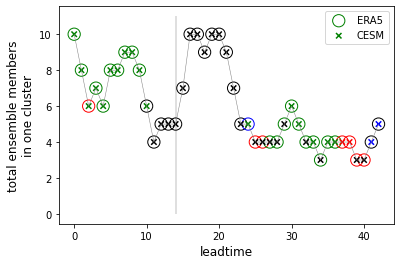

Indices of dim_1: 84


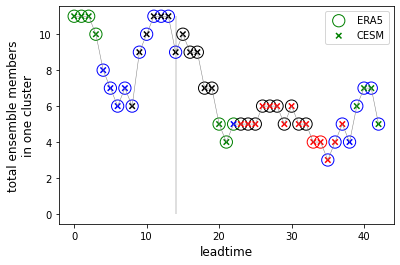

Indices of dim_1: 109


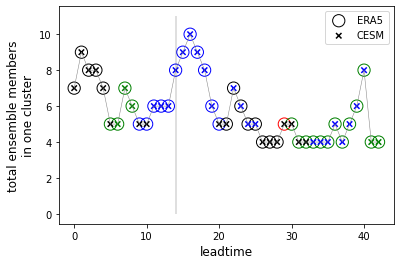

Indices of dim_1: 133


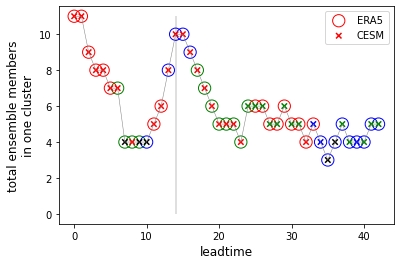

Indices of dim_1: 178


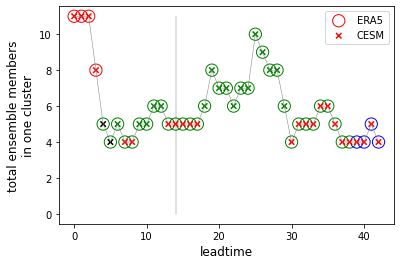

Indices of dim_1: 206


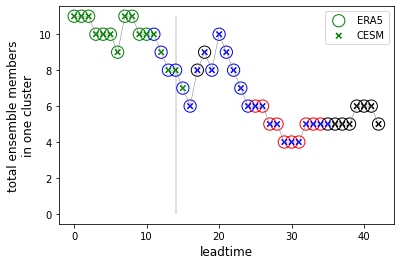

Indices of dim_1: 257


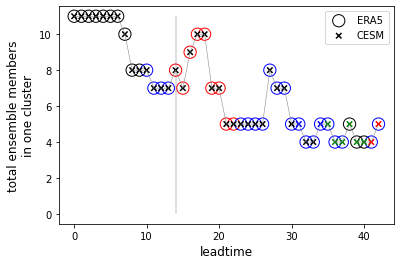

Indices of dim_1: 258


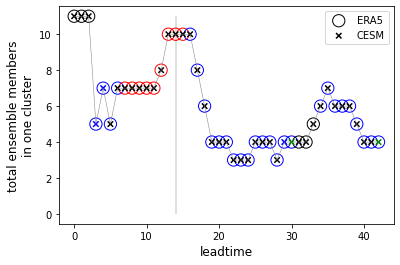

Indices of dim_1: 321


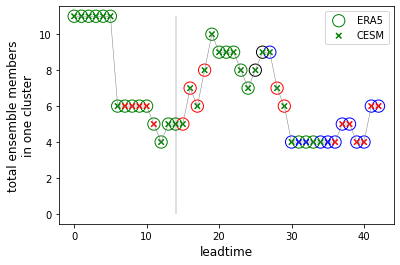

Indices of dim_1: 339


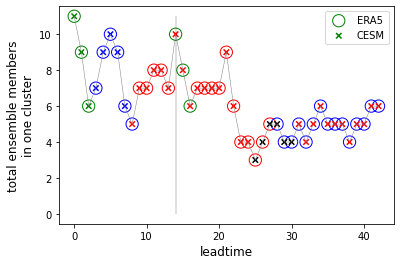

Indices of dim_1: 362


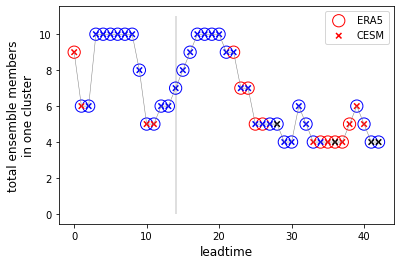

Indices of dim_1: 406


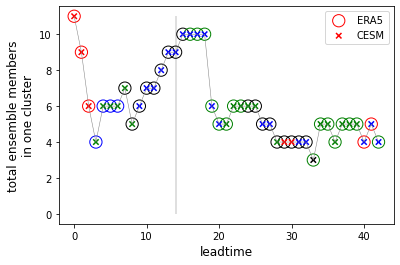

Indices of dim_1: 414


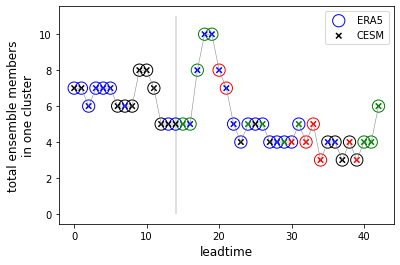

Indices of dim_1: 461


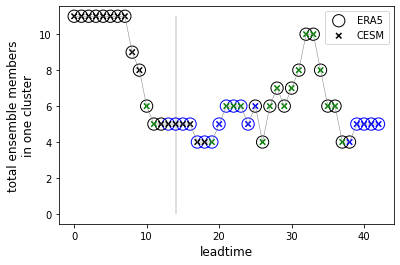

In [17]:
plt.figure(figsize=(6,4))

for dm_ in np.unique(dim_1):
    
    wr_c_list = []
    for i in ensm_mode[0,dm_,:]:
        wr_c_list.append(wr_color[int(i)])
        
    wr_e_list = []
    for i in cluster_era5_evo[0,dm_,:]:
        wr_e_list.append(wr_color[int(i)])
    
    plt.plot(np.arange(0,43,1), ensm_count[0,dm_,:], lw=0.5, c='grey')
    plt.vlines(cutoff_day, 0, 11, colors='k', lw=0.25)
    
    l1 = plt.scatter(np.arange(0,43,1), ensm_count[0,dm_,:], s=150, marker='o', edgecolor=wr_e_list, facecolor='none')
    l2 = plt.scatter(np.arange(0,43,1), ensm_count[0,dm_,:], s=30,  marker='x', c=wr_c_list)
    
    plt.legend([l1,l2],['ERA5','CESM'])
    plt.ylabel('total ensemble members\nin one cluster', fontsize=12)
    plt.xlabel('leadtime', fontsize=12)
    plt.title(print('Indices of dim_1:', dm_))
    plt.show()

## hovmoller diagrams

Phase 1 & 8 - Western Hemisphere And Africa

Phase 2 & 3 - Indian Ocean

Phase 4 & 5 - Maritime Continent

Phase 6 & 7 - Western Pacific.

Currently the signal is a weak one as seen in this phase diagram MJO Phase diagram

When the MJO signal is strong it's amplitude will be greater than 1 and the contour line will be outside the circle. It should be noted that the MJO is an empircal index consisting of the 850 hPa winds, OLR and 200 hPa winds.

MJO passage through phase 6 and 7 is always of global interest as the impact can be of planetary scale. Usually El Ninos are preceded by Westerly Wind Bursts and the forcing factor can be a MJO passage through phase 6 and 7.

One can look at the raw data of the signal here - RMM Index text. This provides the amplitude of the signal as well as the phase of the MJO.

Another version of the same can be seen here - MJO RMM index

In [18]:
# mjo_csv = pd.read_csv('/glade/scratch/molina/s2s/MJO_1996-2002.csv')

In [19]:
weights = np.cos(np.deg2rad(rlut_era5_tmp.unstack('flat').lat.values))
weights2 = np.cos(np.deg2rad(rlut_era5_tmp2.unstack('flat').lat.values))

In [20]:
cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0.2, 1.0)

In [21]:
square1 = mlines.Line2D([], [], color='firebrick', marker='s', linestyle='None',
                        markersize=10, label='square1')
square2 = mlines.Line2D([], [], color='darkgoldenrod', marker='s', linestyle='None',
                        markersize=10, label='square2')
square3 = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                        markersize=10, label='square3')
square4 = mlines.Line2D([], [], color='turquoise', marker='s', linestyle='None',
                        markersize=10, label='square4')

In [22]:
# load states for plotting
reader = shpreader.Reader(
    '/glade/work/molina/DATA/cartopy_usstates/ne_50m_admin_1_states_provinces_lines.shp')
states = list(reader.geometries())
STATES = cfeature.ShapelyFeature(states, ccrs.PlateCarree())

## Figure 9

/glade/scratch/molina/ipykernel_157777/302271121.py:323: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


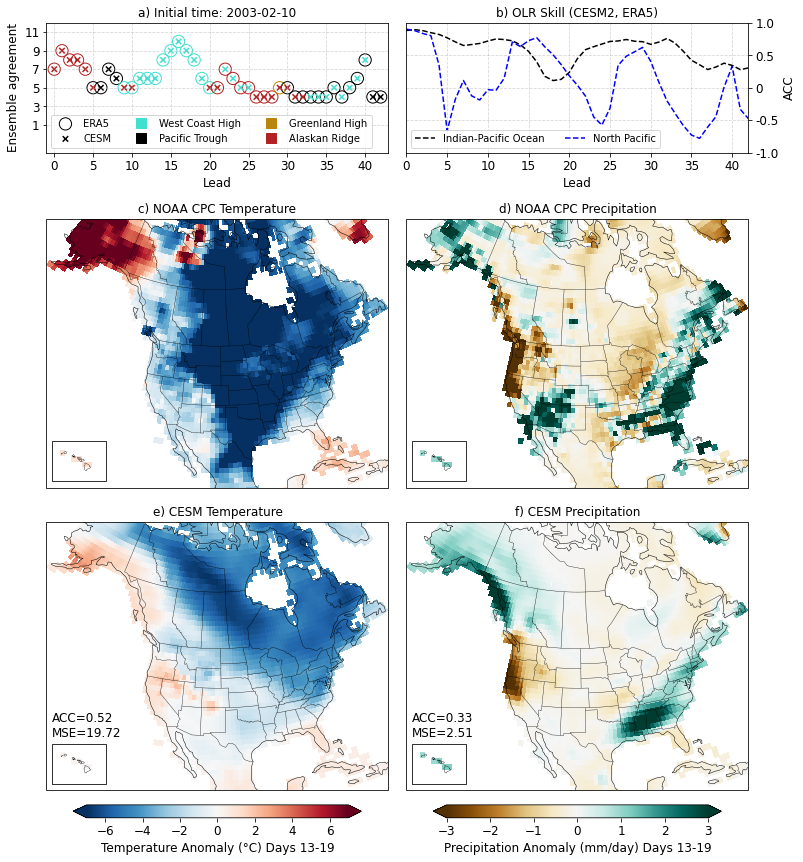

In [23]:
# -- ## -- ## -- ## -- ## --


dm_ = 109

lead0 = 13
lead1 = 19

wr_color = ['firebrick', 'darkgoldenrod', 'k', 'turquoise']

proj = ccrs.LambertConformal(central_latitude=39,
                             central_longitude=-105,
                             standard_parallels=(33, 45))


# -- ## -- ## -- ## --

# -- plot a


wr_c_list = []
for i in ensm_mode[0, dm_, :]:
    wr_c_list.append(wr_color[int(i)])

wr_e_list = []
for i in cluster_era5_evo[0, dm_, :]:
    wr_e_list.append(wr_color[int(i)])


# -- plot b

# indian-pacific olr

avg_data1 = (
    (-rlut_era5_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data2 = (
    (rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill = []
for pl in range(43):
    mjo_skill.append(stats.pearsonr(avg_data1[pl, :], avg_data2[pl, :])[0])

# north pacific olr

avg_data12 = (
    (-rlut_era5_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data22 = (
    (rlut_cesm_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill2 = []
for pl in range(43):
    mjo_skill2.append(stats.pearsonr(avg_data12[pl, :], avg_data22[pl, :])[0])


# -- plots c-f (temp and precip)


pr_ncpc_week34 = pr_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_ncpc_week34 = t2m_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

pr_cesm_week34 = pr_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_cesm_week34 = t2m_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


fig = plt.figure(figsize=(10, 12))

ax1 = plt.axes([0.0, 0.82, 0.475, 0.15])
ax2 = plt.axes([0.5, 0.82, 0.475, 0.15])
ax3 = plt.axes([0.0, 0.35, 0.475, 0.475], projection=proj)
ax4 = plt.axes([0.5, 0.35, 0.475, 0.475], projection=proj)
ax5 = plt.axes([0.0, 0.00, 0.475, 0.475], projection=proj)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=150, marker='o', 
    edgecolor=wr_e_list, facecolor='none')

l2 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=30, marker='x', c=wr_c_list)

leg = ax1.legend([l1, l2, square4, square3, square2, square1],
                 ['ERA5', 'CESM',
                  'West Coast High',
                  'Pacific Trough',
                  'Greenland High',
                  'Alaskan Ridge'],
                 fancybox=True, ncol=3, loc='lower left', fontsize=10)

leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_edgecolor('k')

ax1.set_ylabel('Ensemble agreement', fontsize=12)
ax1.set_xlabel('Lead', fontsize=12)

ax1.set_xticks(np.arange(0, 43, 1)[::5])
ax1.set_xticklabels(np.arange(0, 43, 1)[::5], fontsize=12)
ax1.set_yticks(np.arange(1, 12, 1)[::2])
ax1.set_yticklabels(np.arange(1, 12, 1)[::2], fontsize=12)

ax1.margins(x=0, y=0)
ax1.set_xlim([-1, 43])
ax1.set_ylim([-2, 12])
ax1.grid(ls='--', alpha=0.5)

ax1.set_title(
    'a) Initial time: '+pd.to_datetime(avg_data1.time.values).strftime('%Y-%m-%d'),
    fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1, = ax2.plot(np.arange(0, 43, 1), mjo_skill, c='k', ls='--', lw=1.5)
l2, = ax2.plot(np.arange(0, 43, 1), mjo_skill2, c='b', ls='--', lw=1.5)

ax2.set_title('b) OLR Skill (CESM2, ERA5)')

ax2.set_xlim([0, 42])
ax2.set_xlabel('Lead', fontsize=12)
ax2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax2.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=12)

ax2.set_ylim([-1.0, 1.0])
ax2.set_ylabel('ACC', fontsize=12)
ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
ax2.set_yticklabels([-1.0, -0.5, 0, 0.5, 1.0], fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax2.margins(x=0, y=0)
ax2.grid(alpha=0.5, ls='--')

ax2.legend([l1, l2],
           ['Indian-Pacific Ocean', 'North Pacific'],
           ncol=2, fancybox=True, fontsize=10)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax3.set_title('c) NOAA CPC Temperature')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax3.pcolormesh(lons, lats, t2_ncpc_week34, transform=ccrs.PlateCarree(), 
               vmin=-7, vmax=7, cmap='RdBu_r', shading='auto')

ax3.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax3.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax3.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax3.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax3.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-7, vmax=7,
    cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax5.set_title('e) CESM Temperature')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs3 = ax5.pcolormesh(lons, lats, t2_cesm_week34, transform=ccrs.PlateCarree(), 
                     vmin=-7, vmax=7, cmap='RdBu_r', shading='auto')

ax5.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax5.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax5.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax5.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax5.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(t2_ncpc_week34.flatten()))
data1_tmp = np.delete(t2_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(t2_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax5.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.075, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, t2_cesm_week34,
             vmin=-7, vmax=7, cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax4.set_title('d) NOAA CPC Precipitation')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax4.pcolormesh(
    lons, lats, pr_ncpc_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax4.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax4.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax4.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax4.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax4.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34,
    vmin=-3, vmax=3, cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax6 = plt.axes([0.5, 0.0, 0.475, 0.475], projection=proj)

ax6.set_title('f) CESM Precipitation')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs4 = ax6.pcolormesh(
    lons, lats, pr_cesm_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax6.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax6.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax6.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax6.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax6.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(pr_ncpc_week34.flatten()))
data1_tmp = np.delete(pr_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(pr_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax6.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.075, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-3, vmax=3,
    cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.0375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-6, -4, -2, 0, 2, 4, 6],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Temperature Anomaly (\N{DEGREE SIGN}C) Days 13-19', fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.5375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=[-3, -2, -1, 0, 1, 2, 3],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Precipitation Anomaly (mm/day) Days 13-19', fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


plt.tight_layout()
plt.savefig(f"fig_case{dm_}.png", bbox_inches='tight', dpi=500)
plt.savefig(f"fig_case{dm_}.pdf", bbox_inches='tight')
plt.show()


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --

## Figure 10

/glade/scratch/molina/ipykernel_157777/23114036.py:320: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


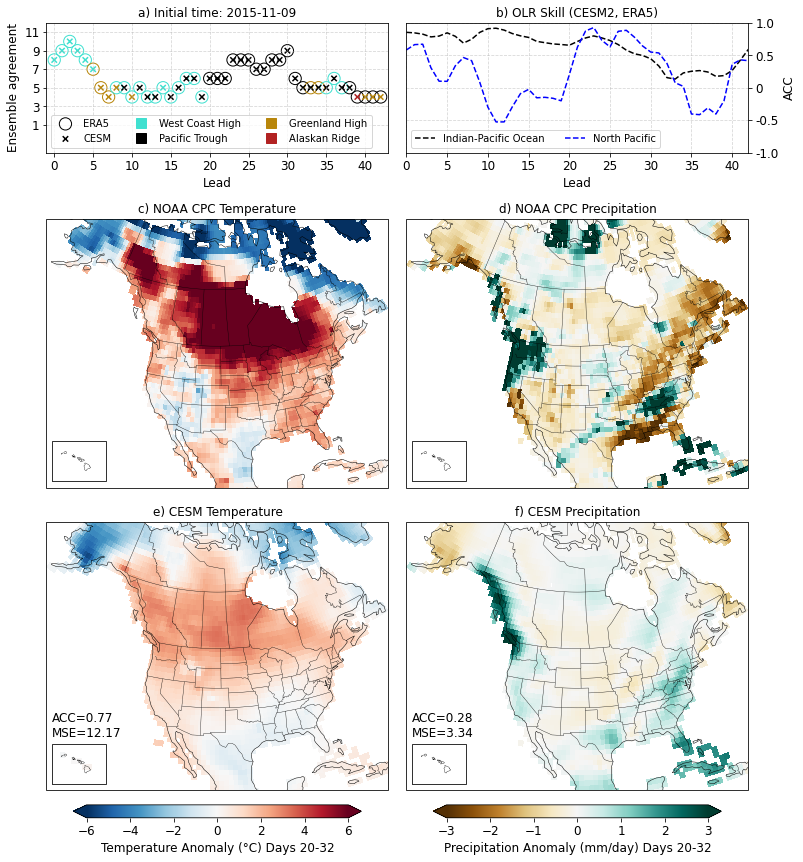

In [24]:
# -- ## -- ## -- ## -- ## --


dm_ = 432

lead0 = 20
lead1 = 32

wr_color = ['firebrick', 'darkgoldenrod', 'k', 'turquoise']

proj = ccrs.LambertConformal(central_latitude=39,
                             central_longitude=-105,
                             standard_parallels=(33, 45))


# -- ## -- ## -- ## --

# -- plot a


wr_c_list = []
for i in ensm_mode[0, dm_, :]:
    wr_c_list.append(wr_color[int(i)])

wr_e_list = []
for i in cluster_era5_evo[0, dm_, :]:
    wr_e_list.append(wr_color[int(i)])


# -- plot b


avg_data1 = (
    (-rlut_era5_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data2 = (
    (rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill = []
for pl in range(43):
    mjo_skill.append(stats.pearsonr(avg_data1[pl, :], avg_data2[pl, :])[0])


avg_data12 = (
    (-rlut_era5_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data22 = (
    (rlut_cesm_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill2 = []
for pl in range(43):
    mjo_skill2.append(stats.pearsonr(avg_data12[pl, :], avg_data22[pl, :])[0])


# -- plots c-f


pr_ncpc_week34 = pr_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_ncpc_week34 = t2m_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

pr_cesm_week34 = pr_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_cesm_week34 = t2m_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


fig = plt.figure(figsize=(10, 12))

ax1 = plt.axes([0.0, 0.82, 0.475, 0.15])
ax2 = plt.axes([0.5, 0.82, 0.475, 0.15])
ax3 = plt.axes([0.0, 0.35, 0.475, 0.475], projection=proj)
ax4 = plt.axes([0.5, 0.35, 0.475, 0.475], projection=proj)
ax5 = plt.axes([0.0, 0.0, 0.475, 0.475], projection=proj)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=150, marker='o', 
    edgecolor=wr_e_list, facecolor='none')

l2 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=30, marker='x', c=wr_c_list)

leg = ax1.legend([l1, l2, square4, square3, square2, square1],
                 ['ERA5', 'CESM',
                  'West Coast High',
                  'Pacific Trough',
                  'Greenland High',
                  'Alaskan Ridge'],
                 fancybox=True, ncol=3, loc='lower left', fontsize=10)

leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_edgecolor('k')

ax1.set_ylabel('Ensemble agreement', fontsize=12)
ax1.set_xlabel('Lead', fontsize=12)

ax1.set_xticks(np.arange(0, 43, 1)[::5])
ax1.set_xticklabels(np.arange(0, 43, 1)[::5], fontsize=12)
ax1.set_yticks(np.arange(1, 12, 1)[::2])
ax1.set_yticklabels(np.arange(1, 12, 1)[::2], fontsize=12)

ax1.margins(x=0, y=0)
ax1.set_xlim([-1, 43])
ax1.set_ylim([-2, 12])
ax1.grid(ls='--', alpha=0.5)

ax1.set_title(
    'a) Initial time: '+pd.to_datetime(avg_data1.time.values).strftime('%Y-%m-%d'),
    fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1, = ax2.plot(np.arange(0, 43, 1), mjo_skill, c='k', ls='--', lw=1.5)
l2, = ax2.plot(np.arange(0, 43, 1), mjo_skill2, c='b', ls='--', lw=1.5)

ax2.set_title('b) OLR Skill (CESM2, ERA5)')

ax2.set_xlim([0, 42])
ax2.set_xlabel('Lead', fontsize=12)
ax2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax2.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=12)

ax2.set_ylim([-1.0, 1.0])
ax2.set_ylabel('ACC', fontsize=12)
ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
ax2.set_yticklabels([-1.0, -0.5, 0, 0.5, 1.0], fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax2.margins(x=0, y=0)
ax2.grid(alpha=0.5, ls='--')

ax2.legend([l1, l2],
           ['Indian-Pacific Ocean', 'North Pacific'],
           ncol=2, fancybox=True, fontsize=10)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax3.set_title('c) NOAA CPC Temperature')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax3.pcolormesh(lons, lats, t2_ncpc_week34, transform=ccrs.PlateCarree(), 
               vmin=-6, vmax=6, cmap='RdBu_r', shading='auto')

ax3.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax3.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax3.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax3.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax3.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-6, vmax=6,
    cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax5.set_title('e) CESM Temperature')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs3 = ax5.pcolormesh(lons, lats, t2_cesm_week34, transform=ccrs.PlateCarree(), 
                     vmin=-6, vmax=6, cmap='RdBu_r', shading='auto')

ax5.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax5.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax5.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax5.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax5.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(t2_ncpc_week34.flatten()))
data1_tmp = np.delete(t2_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(t2_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax5.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.075, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, t2_cesm_week34, 
             vmin=-6, vmax=6, cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax4.set_title('d) NOAA CPC Precipitation')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax4.pcolormesh(
    lons, lats, pr_ncpc_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax4.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax4.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax4.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax4.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax4.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34,
    vmin=-3, vmax=3, cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax6 = plt.axes([0.5, 0.0, 0.475, 0.475], projection=proj)

ax6.set_title('f) CESM Precipitation')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs4 = ax6.pcolormesh(
    lons, lats, pr_cesm_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax6.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax6.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax6.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax6.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax6.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(pr_ncpc_week34.flatten()))
data1_tmp = np.delete(pr_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(pr_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax6.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.075, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-3, vmax=3,
    cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.0375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-6, -4, -2, 0, 2, 4, 6],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Temperature Anomaly (\N{DEGREE SIGN}C) Days 20-32', fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.5375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=[-3, -2, -1, 0, 1, 2, 3],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Precipitation Anomaly (mm/day) Days 20-32', fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


plt.tight_layout()
plt.savefig(f"fig_case{dm_}.png", bbox_inches='tight', dpi=500)
plt.savefig(f"fig_case{dm_}.pdf", bbox_inches='tight')
plt.show()


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --

## Figure 11

/glade/scratch/molina/ipykernel_157777/2370428908.py:321: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


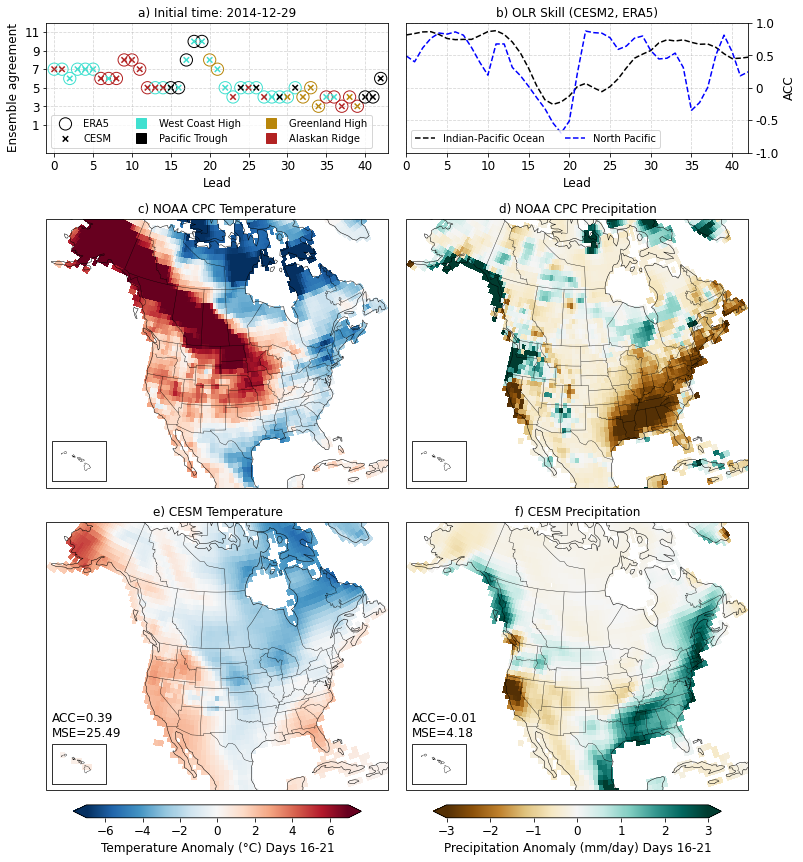

In [25]:
# -- ## -- ## -- ## -- ## --


dm_ = 414

lead0 = 16
lead1 = 21

wr_color = ['firebrick', 'darkgoldenrod', 'k', 'turquoise']

proj = ccrs.LambertConformal(central_latitude=39,
                             central_longitude=-105,
                             standard_parallels=(33, 45))


# -- ## -- ## -- ## --

# -- plot a


wr_c_list = []
for i in ensm_mode[0, dm_, :]:
    wr_c_list.append(wr_color[int(i)])

wr_e_list = []
for i in cluster_era5_evo[0, dm_, :]:
    wr_e_list.append(wr_color[int(i)])


# -- plot b


avg_data1 = (
    (-rlut_era5_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data2 = (
    (rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill = []
for pl in range(43):
    mjo_skill.append(stats.pearsonr(avg_data1[pl, :], avg_data2[pl, :])[0])


avg_data12 = (
    (-rlut_era5_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data22 = (
    (rlut_cesm_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill2 = []
for pl in range(43):
    mjo_skill2.append(stats.pearsonr(avg_data12[pl, :], avg_data22[pl, :])[0])


# -- plots c-f


pr_ncpc_week34 = pr_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_ncpc_week34 = t2m_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

pr_cesm_week34 = pr_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_cesm_week34 = t2m_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


fig = plt.figure(figsize=(10, 12))

ax1 = plt.axes([0.0, 0.82, 0.475, 0.15])
ax2 = plt.axes([0.5, 0.82, 0.475, 0.15])
ax3 = plt.axes([0.0, 0.35, 0.475, 0.475], projection=proj)
ax4 = plt.axes([0.5, 0.35, 0.475, 0.475], projection=proj)
ax5 = plt.axes([0.0, 0.0, 0.475, 0.475], projection=proj)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=150, marker='o', 
    edgecolor=wr_e_list, facecolor='none')

l2 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=30, marker='x', c=wr_c_list)

leg = ax1.legend([l1, l2, square4, square3, square2, square1],
                 ['ERA5', 'CESM',
                  'West Coast High',
                  'Pacific Trough',
                  'Greenland High',
                  'Alaskan Ridge'],
                 fancybox=True, ncol=3, loc='lower left', fontsize=10)

leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_edgecolor('k')

ax1.set_ylabel('Ensemble agreement', fontsize=12)
ax1.set_xlabel('Lead', fontsize=12)

ax1.set_xticks(np.arange(0, 43, 1)[::5])
ax1.set_xticklabels(np.arange(0, 43, 1)[::5], fontsize=12)
ax1.set_yticks(np.arange(1, 12, 1)[::2])
ax1.set_yticklabels(np.arange(1, 12, 1)[::2], fontsize=12)

ax1.margins(x=0, y=0)
ax1.set_xlim([-1, 43])
ax1.set_ylim([-2, 12])
ax1.grid(ls='--', alpha=0.5)

ax1.set_title(
    'a) Initial time: '+pd.to_datetime(avg_data1.time.values).strftime('%Y-%m-%d'),
    fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1, = ax2.plot(np.arange(0, 43, 1), mjo_skill, c='k', ls='--', lw=1.5)
l2, = ax2.plot(np.arange(0, 43, 1), mjo_skill2, c='b', ls='--', lw=1.5)

ax2.set_title('b) OLR Skill (CESM2, ERA5)')

ax2.set_xlim([0, 42])
ax2.set_xlabel('Lead', fontsize=12)
ax2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax2.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=12)

ax2.set_ylim([-1.0, 1.0])
ax2.set_ylabel('ACC', fontsize=12)
ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
ax2.set_yticklabels([-1.0, -0.5, 0, 0.5, 1.0], fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax2.margins(x=0, y=0)
ax2.grid(alpha=0.5, ls='--')

ax2.legend([l1, l2],
           ['Indian-Pacific Ocean', 'North Pacific'],
           ncol=2, fancybox=True, fontsize=10)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax3.set_title('c) NOAA CPC Temperature')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax3.pcolormesh(lons, lats, t2_ncpc_week34, transform=ccrs.PlateCarree(), 
               vmin=-7, vmax=7, cmap='RdBu_r', shading='auto')

ax3.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax3.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax3.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax3.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax3.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-7, vmax=7,
    cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax5.set_title('e) CESM Temperature')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs3 = ax5.pcolormesh(lons, lats, t2_cesm_week34, transform=ccrs.PlateCarree(), 
                     vmin=-7, vmax=7, cmap='RdBu_r', shading='auto')

ax5.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax5.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax5.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax5.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax5.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(t2_ncpc_week34.flatten()))
data1_tmp = np.delete(t2_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(t2_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax5.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.075, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, t2_cesm_week34,
             vmin=-7, vmax=7, cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax4.set_title('d) NOAA CPC Precipitation')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax4.pcolormesh(
    lons, lats, pr_ncpc_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax4.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax4.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax4.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax4.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax4.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34,
    vmin=-3, vmax=3, cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax6 = plt.axes([0.5, 0.0, 0.475, 0.475], projection=proj)

ax6.set_title('f) CESM Precipitation')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs4 = ax6.pcolormesh(
    lons, lats, pr_cesm_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax6.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax6.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax6.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax6.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax6.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(pr_ncpc_week34.flatten()))
data1_tmp = np.delete(pr_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(pr_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax6.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.075, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-3, vmax=3,
    cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.0375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-6, -4, -2, 0, 2, 4, 6],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Temperature Anomaly (\N{DEGREE SIGN}C) Days 16-21', 
               fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.5375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=[-3, -2, -1, 0, 1, 2, 3],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Precipitation Anomaly (mm/day) Days 16-21', fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


plt.tight_layout()
plt.savefig(f"fig_case{dm_}.png", bbox_inches='tight', dpi=500)
plt.savefig(f"fig_case{dm_}.pdf", bbox_inches='tight')
plt.show()


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --

## Figure 12

/glade/scratch/molina/ipykernel_157777/4037280418.py:320: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


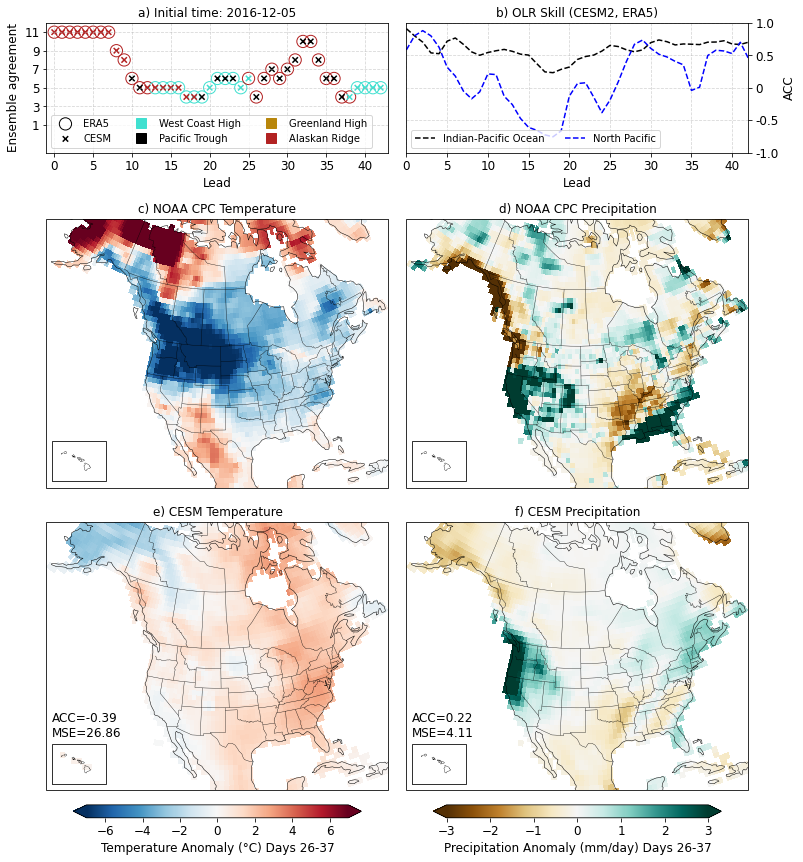

In [26]:
# -- ## -- ## -- ## -- ## --


dm_ = 461

lead0 = 26
lead1 = 37

wr_color = ['firebrick', 'darkgoldenrod', 'k', 'turquoise']

proj = ccrs.LambertConformal(central_latitude=39,
                             central_longitude=-105,
                             standard_parallels=(33, 45))


# -- ## -- ## -- ## --

# -- plot a


wr_c_list = []
for i in ensm_mode[0, dm_, :]:
    wr_c_list.append(wr_color[int(i)])

wr_e_list = []
for i in cluster_era5_evo[0, dm_, :]:
    wr_e_list.append(wr_color[int(i)])


# -- plot b


avg_data1 = (
    (-rlut_era5_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data2 = (
    (rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill = []
for pl in range(43):
    mjo_skill.append(stats.pearsonr(avg_data1[pl, :], avg_data2[pl, :])[0])


avg_data12 = (
    (-rlut_era5_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data22 = (
    (rlut_cesm_tmp2.unstack('flat').unstack('new').transpose(
        'time', 'lead', 'lat', 'lon').isel(time=dm_) * weights2[None, :, None]).sum(
        dim='lat', skipna=True) / np.sum(weights2)).rolling(
    lon=3, min_periods=1, center=True).mean()

mjo_skill2 = []
for pl in range(43):
    mjo_skill2.append(stats.pearsonr(avg_data12[pl, :], avg_data22[pl, :])[0])


# -- plots c-f


pr_ncpc_week34 = pr_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_ncpc_week34 = t2m_noaa.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

pr_cesm_week34 = pr_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values

t2_cesm_week34 = t2m_cesm.transpose('time', 'lead', 'lat', 'lon').isel(
    time=dm_).isel(lead=slice(lead0, lead1)).mean('lead', skipna=True).values


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


fig = plt.figure(figsize=(10, 12))

ax1 = plt.axes([0.0, 0.82, 0.475, 0.15])
ax2 = plt.axes([0.5, 0.82, 0.475, 0.15])
ax3 = plt.axes([0.0, 0.35, 0.475, 0.475], projection=proj)
ax4 = plt.axes([0.5, 0.35, 0.475, 0.475], projection=proj)
ax5 = plt.axes([0.0, 0.0, 0.475, 0.475], projection=proj)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=150, marker='o', 
    edgecolor=wr_e_list, facecolor='none')

l2 = ax1.scatter(
    np.arange(0, 43, 1), ensm_count[0, dm_, :], s=30, marker='x', c=wr_c_list)

leg = ax1.legend([l1, l2, square4, square3, square2, square1],
                 ['ERA5', 'CESM',
                  'West Coast High',
                  'Pacific Trough',
                  'Greenland High',
                  'Alaskan Ridge'],
                 fancybox=True, ncol=3, loc='lower left', fontsize=10)

leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_edgecolor('k')

ax1.set_ylabel('Ensemble agreement', fontsize=12)
ax1.set_xlabel('Lead', fontsize=12)

ax1.set_xticks(np.arange(0, 43, 1)[::5])
ax1.set_xticklabels(np.arange(0, 43, 1)[::5], fontsize=12)
ax1.set_yticks(np.arange(1, 12, 1)[::2])
ax1.set_yticklabels(np.arange(1, 12, 1)[::2], fontsize=12)

ax1.margins(x=0, y=0)
ax1.set_xlim([-1, 43])
ax1.set_ylim([-2, 12])
ax1.grid(ls='--', alpha=0.5)

ax1.set_title(
    'a) Initial time: '+pd.to_datetime(avg_data1.time.values).strftime('%Y-%m-%d'),
    fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


l1, = ax2.plot(np.arange(0, 43, 1), mjo_skill, c='k', ls='--', lw=1.5)
l2, = ax2.plot(np.arange(0, 43, 1), mjo_skill2, c='b', ls='--', lw=1.5)

ax2.set_title('b) OLR Skill (CESM2, ERA5)')

ax2.set_xlim([0, 42])
ax2.set_xlabel('Lead', fontsize=12)
ax2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax2.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=12)

ax2.set_ylim([-1.0, 1.0])
ax2.set_ylabel('ACC', fontsize=12)
ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
ax2.set_yticklabels([-1.0, -0.5, 0, 0.5, 1.0], fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax2.margins(x=0, y=0)
ax2.grid(alpha=0.5, ls='--')

ax2.legend([l1, l2],
           ['Indian-Pacific Ocean', 'North Pacific'],
           ncol=2, fancybox=True, fontsize=10)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax3.set_title('c) NOAA CPC Temperature')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax3.pcolormesh(lons, lats, t2_ncpc_week34, transform=ccrs.PlateCarree(), 
               vmin=-7, vmax=7, cmap='RdBu_r', shading='auto')

ax3.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax3.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax3.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax3.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax3.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-7, vmax=7,
    cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax5.set_title('e) CESM Temperature')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs3 = ax5.pcolormesh(lons, lats, t2_cesm_week34, transform=ccrs.PlateCarree(), 
                     vmin=-7, vmax=7, cmap='RdBu_r', shading='auto')

ax5.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax5.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax5.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax5.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax5.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(t2_ncpc_week34.flatten()))
data1_tmp = np.delete(t2_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(t2_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax5.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0075, 0.075, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, t2_cesm_week34,
             vmin=-7, vmax=7, cmap='RdBu_r')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax4.set_title('d) NOAA CPC Precipitation')

lons, lats = np.meshgrid(t2m_era5.lon.values, t2m_era5.lat.values)

ax4.pcolormesh(
    lons, lats, pr_ncpc_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax4.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax4.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax4.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax4.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax4.margins(x=0, y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.425, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34,
    vmin=-3, vmax=3, cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


ax6 = plt.axes([0.5, 0.0, 0.475, 0.475], projection=proj)

ax6.set_title('f) CESM Precipitation')

lons, lats = np.meshgrid(t2m_cesm.lon.values, t2m_cesm.lat.values)

cs4 = ax6.pcolormesh(
    lons, lats, pr_cesm_week34, transform=ccrs.PlateCarree(),
    vmin=-3, vmax=3, cmap='BrBG', shading='auto')

ax6.coastlines(
    resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
ax6.add_feature(
    STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax6.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
ax6.set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())
ax6.margins(x=0, y=0)

nan_indx = np.argwhere(np.isnan(pr_ncpc_week34.flatten()))
data1_tmp = np.delete(pr_ncpc_week34.flatten(), nan_indx)
data2_tmp = np.delete(pr_cesm_week34.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp, data2_tmp)[0], 2)
mse = np.around(metrics.mean_squared_error(data1_tmp, data2_tmp), 2)

ax6.annotate(
    f'ACC={r}\nMSE={mse}', xy=(0.015, 0.2), xycoords='axes fraction', zorder=100,
    fontsize=12)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.5075, 0.075, 0.075, 0.075)
add_insetmap(
    axes_extent, map_extent, lons, lats, t2_ncpc_week34, vmin=-3, vmax=3,
    cmap='BrBG')


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.0375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-6, -4, -2, 0, 2, 4, 6],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Temperature Anomaly (\N{DEGREE SIGN}C) Days 26-37', fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


cbar_ax = fig.add_axes([0.5375, 0.05, 0.4, 0.015])

cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=[-3, -2, -1, 0, 1, 2, 3],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Precipitation Anomaly (mm/day) Days 26-37', fontsize=12)


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


plt.tight_layout()
plt.savefig(f"fig_case{dm_}.png", bbox_inches='tight', dpi=500)
plt.savefig(f"fig_case{dm_}.pdf", bbox_inches='tight')
plt.show()


# -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --